In [1]:

from monai.transforms import (Compose)
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from monai.data import decollate_batch
import torch
import json


In [2]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']


--------
# Ga

In [ ]:
# from data_preparation import DataHandling 

# data_handler = DataHandling(ga_data_dir, train_mode="NAC", target_mode="MAC")

# train_files = data_handler.get_data_split('train')
# val_files = data_handler.get_data_split('val')
# test_files = data_handler.get_data_split('test')
# print(len(train_files))
# print(len(val_files))
# print(len(test_files))

# from data_preparation import LoaderFactory
# loader_factory = LoaderFactory(
#     train_files=train_files,
#     val_files=val_files,
#     test_files=test_files,
#     patch_size = [168, 168, 16],
#     spacing = [4.07, 4.07, 3.00],
#     # spacing = [1.92, 1.92, 3.27], # For fdg data
#     spatial_size = (168, 168, 400)
#     # spatial_size = (336, 336, 640) # for Fdg data
#     )

# test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)



----------
# FDG

In [3]:
from data_preparation import ExternalRadioSetHandling, LoaderFactory

data_handler = ExternalRadioSetHandling(data_dir=fdg_data_dir, test_ratio=0.2)
train_files, val_files, test_files = data_handler.get_split_data()

print(f"Test data length: {len(test_files)}")
print(f"Validation data length: {len(val_files)}")
print(f"Train data length: {len(train_files)}")


loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    spatial_size = (168, 168, 600) 
    )

# train_loader = loader_factory.get_loader('train', batch_size=4, num_workers=2, shuffle=True)
# val_loader = loader_factory.get_loader('val', batch_size=1, num_workers=2, shuffle=False)
test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)


Test data length: 21
Validation data length: 15
Train data length: 62


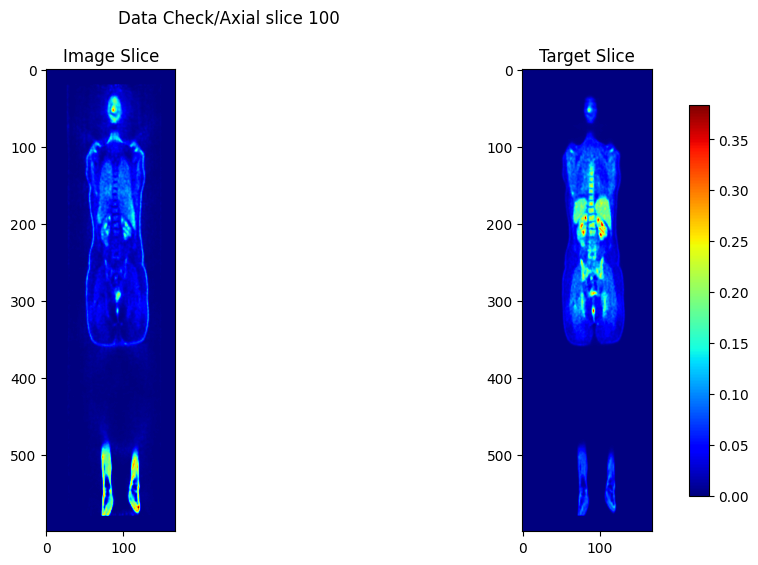

In [4]:
from vis import visualize_axial_slice, visualize_coronal_slice


slice_index = 100  # Example slice index.
visualize_coronal_slice(test_loader, slice_index)


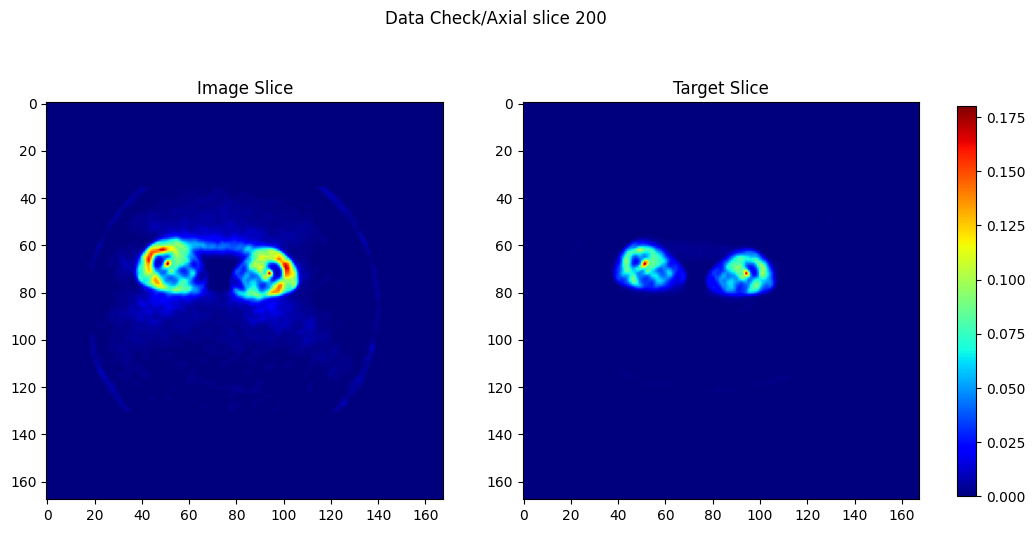

In [5]:
slice_index = 200  # Example slice index.
visualize_axial_slice(test_loader, slice_index)



In [38]:
from utils import find_last_saved_model, parse_loss_values

# log_filename = 'log_2_26_8_17.txt' # saved on hard
# log_filename = 'log_3_4_12_4.txt' # saved on hard
# log_filename = 'log_3_4_12_41.txt' # saved on hard
log_filename = 'log_3_18.txt'
log_filename = 'log_3_27_8_47.txt' # Tuned for fdg
# log_filename = 'log_3_28_6_8.txt'
# log_filename = 'log_3_28_10_41.txt'
# log_filename = 'log_3_28_20_48.txt'
# log_filename = 'log_3_29_6_54.txt'
# log_filename = 'log_4_6_8_55.txt'
log_filename = 'log_4_17_16_3.txt'
log_filename = 'log_4_17_19_29.txt' # Ga, new structure. editesh kardam payini ro ezaf kardam behesh.
# log_filename = 'log_4_23_21_47.txt' # Edameye log_4_17_19_29

log_filename = 'log_5_3_15_18.txt' # Tuned for fdg lr = 0.00001
log_filename = 'log_5_4_7_19.txt' # Tuned for fdg lr = 0.0001
log_filename = 'log_5_4_19_58.txt' # Tuned for fdg lr = 0.001
log_filename = 'log_5_4.txt' # Tuned for fdg lr = 0.001 khodam save kardam ta epoch 20

log_filepath = log_dir + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_5_4_23_20.pth, Best Metric: 0.0014, Epoch: 10


In [ ]:
# bestmodel_filename =  'model_4_2_0_41.pth'

# best_metric = 0.3338
# best_epoch = 38

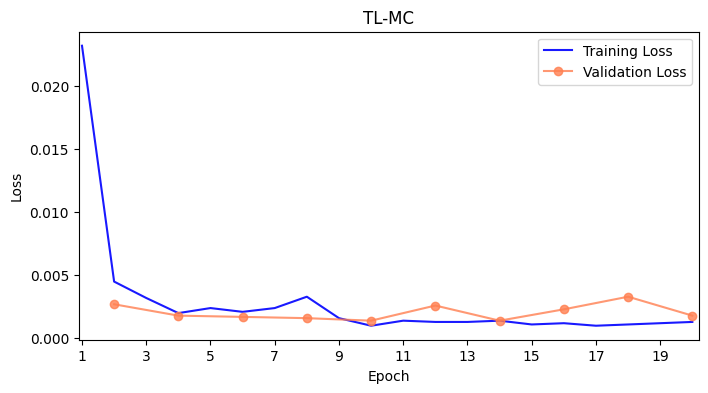

In [71]:
import matplotlib.pyplot as plt
import numpy as np



train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
start_epoch = 1  # Can be set to any valid epoch number, including 1
val_interval = 2  # Update this if your validation interval is different

# Ensure start_epoch is within the range of available data
start_epoch = max(1, min(start_epoch, max_epochs))

# Create arrays for epoch numbers
epochs = np.arange(1, max_epochs + 1)
val_epochs = np.arange(2, max_epochs + 1, val_interval)

# Plotting
plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(val_epochs, [val for val in val_losses if not np.isnan(val)], 'o-', label='Validation Loss', color='coral', alpha=0.8)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TL-MC')
plt.legend()
plt.xlim(0.9, 20.2)
plt.xticks(np.arange(1, max_epochs+1, 2))  # Show every epoch
# plt.grid(True)

plt.show()

In [74]:
import os
import torch
from model_maker import get_network, add_activation_before_output
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_network(patch_size = [168, 168, 16], spacing = [4.07, 4.07, 3.00])

model = model.to(device)

add_activation_before_output(model, nn.ReLU(inplace=True))
model

DyUnet is set:
Kernel size:  [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides:  [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]


DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(64, eps=1e-05

In [75]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(log_dir, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_5_4_23_20.pth is loading.


In [76]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
test_name


[('006006_dataset_07_A.nii', '006006_dataset_07_A.nii'),
 ('006010_dataset_07_A.nii', '006010_dataset_07_A.nii'),
 ('006051_dataset_07_A.nii', '006051_dataset_07_A.nii'),
 ('005073_dataset_06_A.nii', '005073_dataset_06_A.nii'),
 ('005060_dataset_06_A_nac_6.nii', '005060_dataset_06_A_nac_6.nii'),
 ('005002_dataset_06_A_nac_6.nii', '005002_dataset_06_A_nac_6.nii'),
 ('005106_dataset_06_A.nii', '005106_dataset_06_A.nii'),
 ('005039_dataset_06_A.nii', '005039_dataset_06_A.nii'),
 ('005005_dataset_06_A.nii', '005005_dataset_06_A.nii'),
 ('005043_dataset_06_A_nac_3.nii', '005043_dataset_06_A_nac_3.nii'),
 ('006044_dataset_07_A.nii', '006044_dataset_07_A.nii'),
 ('006046_dataset_07_A.nii', '006046_dataset_07_A.nii'),
 ('006024_dataset_07_A.nii', '006024_dataset_07_A.nii'),
 ('006041_dataset_07_A.nii', '006041_dataset_07_A.nii'),
 ('006037_dataset_07_A.nii', '006037_dataset_07_A.nii'),
 ('005037_dataset_06_A.nii', '005037_dataset_06_A.nii'),
 ('006007_dataset_07_A.nii', '006007_dataset_07_A.ni

100%|██████████| 2/2 [00:14<00:00,  7.46s/it]


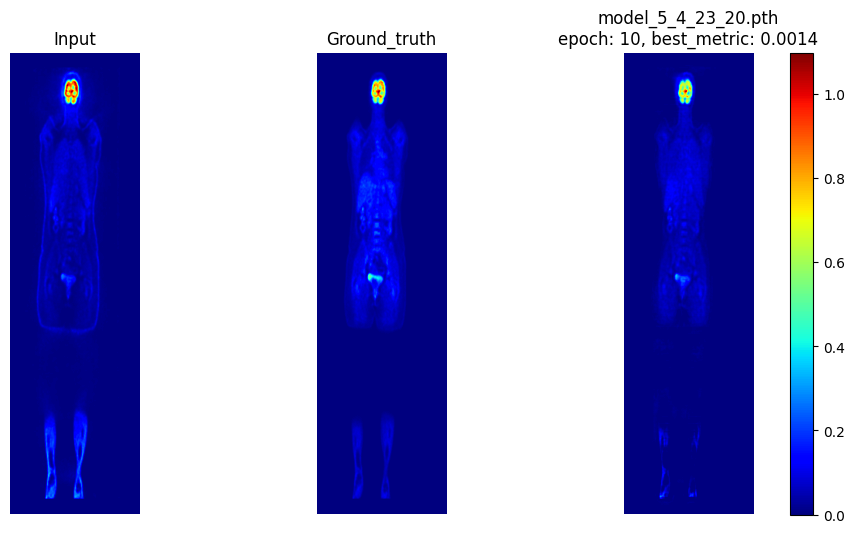

100%|██████████| 2/2 [00:12<00:00,  6.38s/it]


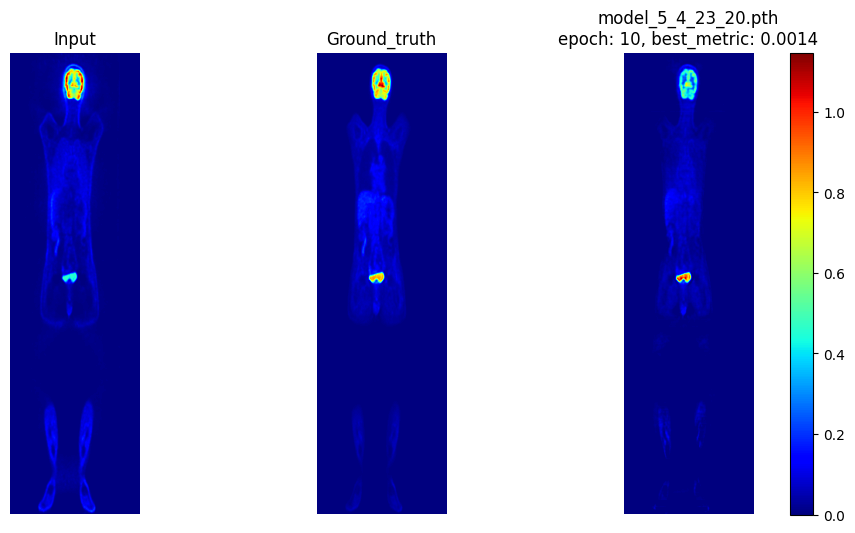

100%|██████████| 2/2 [00:12<00:00,  6.49s/it]


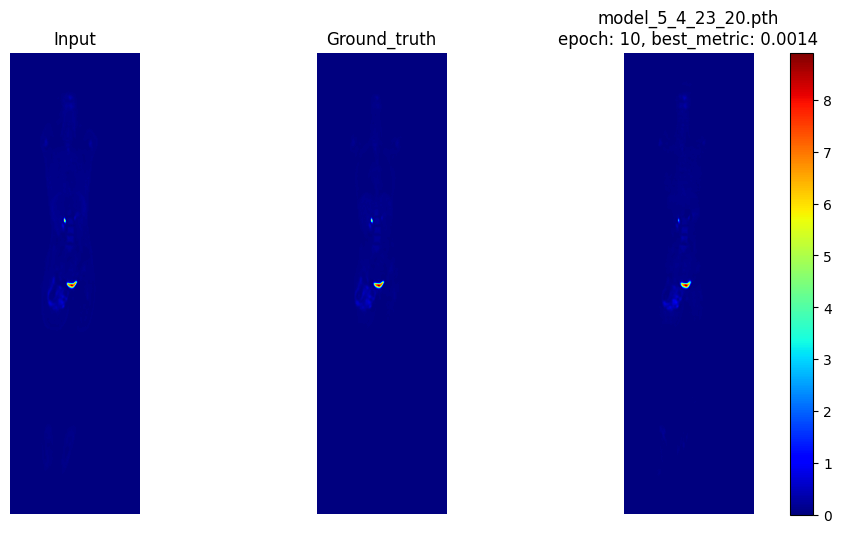

In [80]:
import torch
from vis import model_visualize_coronal

roi_size = (168, 168, 16)
sw_batch_size = 64
slice_number = 95

with torch.no_grad():
    for i, data in enumerate(test_loader):

        predict = sliding_window_inference(data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70)
        
        model_visualize_coronal(data, predict, slice_number, 
                                f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}", 
                                "jet", Norm=False)
        if i == 2:
            break


In [83]:

from monai.transforms import Compose
from data_preparation import ClampNegative

roi_size = (168, 168, 16)
sw_batch_size = 64


post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=loader_factory.get_test_transforms(),
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        # ClampNegative(keys=["pred"]),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=fdg_output_dir, output_postfix="comb_4_5_onfdg", resample=False), 
    ]
)
# comb_3_27_onfdg_v2 fdg_output_dir
# dl4_23 ga_output_dir
# comb_4_5_onfdg fdg_output_dir

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.90)
        post_processed = [post_transforms(i) for i in decollate_batch(test_data)]

